In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 8:1:1**

In [3]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/VPB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [4]:
df

,Price
0,10676.9
1,10687.7
2,10698.5
3,11195.6
4,11498.2
...,...
1246,19450.0
1247,19300.0
1248,19400.0
1249,19850.0


**3. Dùng model ARIMA để train data**

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00


In [6]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14463.739, Time=3.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14472.215, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14470.421, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14470.532, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14471.005, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14474.261, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14474.280, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14460.807, Time=4.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14476.105, Time=1.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=14440.206, Time=7.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=14472.678, Time=1.89 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=14440.448, Time=5.48 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=14441.101, Time=7.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14440.789, Time=2.87 sec
 ARIMA(5,1,1)(0,0,0

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [7]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

**5. Quá trình validate**

In [8]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [9]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[20229.66846748 20345.56628627 20167.07871309 20317.88014145
 20281.11929936 20193.68800401 20338.9707242  20227.84770288
 20243.81768394 20321.16820477 20206.76967386 20286.85188193
 20283.95706573 20217.0460381  20306.36274342 20249.59002315
 20244.39263626 20301.2285369  20232.11667126 20271.58046373
 20281.3931579  20233.84616257 20286.84070532 20260.079371
 20248.01764201 20287.27220449 20247.014867   20264.57738712
 20277.32767344 20245.29735268]


***7.Đánh giá độ chính xác thuật toán***

In [10]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 1913.5307037674504
Testing RMSE: 2591.4171293248482
Validation MAPE: 8.87056390537079
Testing MAPE: 11.79287452621067
Validation MAE: 1595.8347902489609
Testing MAE: 1978.5982253057527


**8. Vẽ biểu đồ**

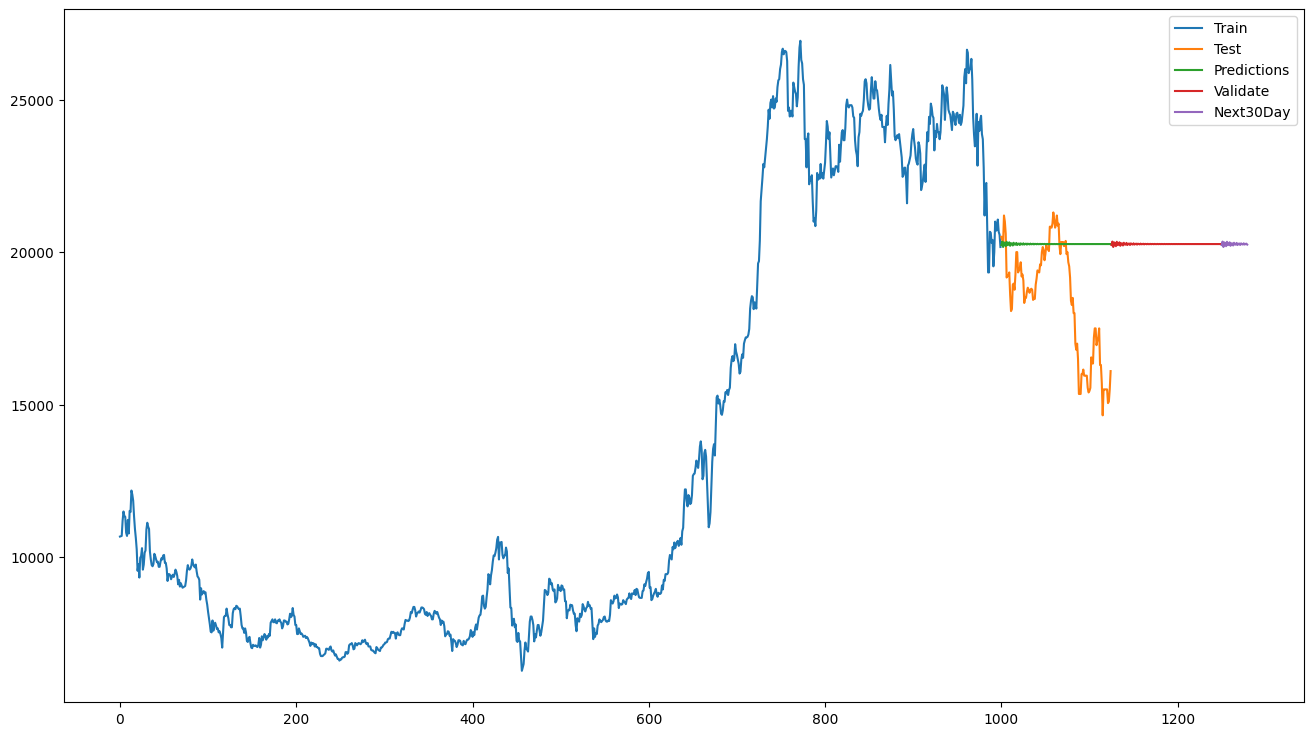

In [11]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()